# NLP: Exploration and summarising text

## Hotel Sample reviews

Notebook structure:

* Clean the raw data
* Do some exploratory analysis on the first hotel in the sample
* Perform some numerical analysis by looking at the Score over the timeline
* Do some time-series analysis on the scores and number of hotel reviews per day
* Look at the text more closely - word frequencies before and after cleaning
* A few ways of cleaning, a little bit of profiling
* Explore semantic relationships
* Create a function to extract descriptive words for given attributes
* Combine all adjectives and select the top 5 by count
* Construct some sentences using the top adjectives

In [1]:
# Standard
import pandas as pd
import numpy as np

# NLP
import spacy
nlp_en = spacy.load('en_default')    # this is the "en_core_web_md" model
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import re
from itertools import permutations
from random import randint, sample

# Machine Learning
import sklearn

# Type-checking
from typing import Sequence, Optional

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]

# Profiling
import cProfile

In [2]:
# Load the raw data
FILE = './sample-reviews.csv'
data = pd.read_csv(FILE, infer_datetime_format=True, header=None, names=['ID', 'Date', 'Score', 'Title', 'Body'])

# have a peek
data.head()

,ID,Date,Score,Title,Body
0,4f6bf0be-e3bd-4f30-ac43-6f3ea424943b,2015-03-22,100.0,excellent hotel,New hotel. Clean rooms. Free wifi. Very friend...
1,4f6bf0be-e3bd-4f30-ac43-6f3ea424943b,2013-09-03,100.0,So much easier in china town,This place is convenient and fun. I would stay...
2,4f6bf0be-e3bd-4f30-ac43-6f3ea424943b,2013-08-22,70.0,NaN,The rooms were nice. Only had single bed rooms...
3,4f6bf0be-e3bd-4f30-ac43-6f3ea424943b,2013-09-29,80.0,NaN,Vanessa was especially helpful. Overall can do...
4,4f6bf0be-e3bd-4f30-ac43-6f3ea424943b,2013-09-16,70.0,NaN,"modern design, breakfast area,close to areas w..."


#####  First observations and Ideas

|Observation|Idea|
|-----------|------|
|2763 reviews|Good number for ML models, not really suited for DL|
|Many reviews don't have titles (NaN values)|Need to check how many and decide if analyses of only titles is feasible|
|Distribution of scores generally seems quite high|Can plot this and take the skew into account if mapping scores to descriptive texts|
|Some reviews are pretty sparse w.r.t. content|High score but only one or two negative words in the content - reconcile this behaviour somehow|
|Dates range|Must be checked and ensured similar for each hotel to treat them all equally|
|Text contains spelling mistakes and colloquial speech|Could try to correct mistakes. Instead, just ensure all text is English|
|Hotel identifiers are ugly|Replace for now just to save screen space and make any plot legends etc. a little nicer|

## Cleaning the data

Basic steps such as imputation, removing duplicates and stopwords, reshaping to make further analysis easier and so on.

In [3]:
# Rename the hotel IDs to something nicer on the eyes
old_names = data.ID.unique()
new_names = ['1.Hotel', '2.Hotel', '3.Hotel']
data.replace(to_replace=old_names, value=new_names, inplace=True)
data.head()

,ID,Date,Score,Title,Body
0,1.Hotel,2015-03-22,100.0,excellent hotel,New hotel. Clean rooms. Free wifi. Very friend...
1,1.Hotel,2013-09-03,100.0,So much easier in china town,This place is convenient and fun. I would stay...
2,1.Hotel,2013-08-22,70.0,NaN,The rooms were nice. Only had single bed rooms...
3,1.Hotel,2013-09-29,80.0,NaN,Vanessa was especially helpful. Overall can do...
4,1.Hotel,2013-09-16,70.0,NaN,"modern design, breakfast area,close to areas w..."


### Missing data

Look to see how many values are missing in each column

In [4]:
cols = data.columns

for col in cols:
    missing = data[col].isnull().sum()/len(data)*100
    print(col, 'missing:\t {:.2f} %'.format(missing))

ID missing:	 0.00 %
Date missing:	 0.00 %
Score missing:	 0.04 %
Title missing:	 23.67 %
Body missing:	 0.04 %


### Decisions

1) The reviews with missing Text fields can just be removed as there are not many of them anyway (~0.04%). Could set a threshold here, e.g. if missing < 5% just remove, otherwise do something to at least retain any other information contained in the review (score, date etc.)

2) Number of missing titles is a bigger issue. Will simply bundle the titles with the review body to make for larger text blocks on each hotel's review. Titles generally include many useful keywords that aren't necessarily contained in the body, so disregarding them would be losing valuable keywords (many NLP studies concentrate exlusively on article titles for that reason). Just to be super clear, **for each review**:

<h1 style="color:blue;text-align:center;font-family:courier">Text = Title + Body</h1>

3) The reviews with missing scores could also be removed as there are few of them, but in order to keep the associated text, just replace NaNs with the mean score for that given hotel. Could leave it out here as it isn't often the case - just do it for the sake of robustness in case future reviews are missing scores. If there were a large number of missing values (e.g. >5%), this would no longer be a robust method, however.

In [5]:
# 1) remove reviews with missing Text
data.drop(data[data.Body.isnull()].index, inplace=True)

In [6]:
# 2) impute missing scores with mean of each hotel
data['Score'] = data.groupby('ID')['Score'].transform(lambda x: x.fillna(x.mean()))

In [7]:
# 3) create a new column containing the concatenated titles and texts, if title is not empty

# Replace the missing titles with empty strings in place of NaN values (for nicer concatenation below)
data['Title'] = data['Title'].fillna('')

# create new column 'Text'; containing the concatenated title and body columns
# The title is simply appended as a new sentence using the sep arg.
data['Text'] = data.Body.astype(str).str.cat(data.Title.astype(str), sep='. ')

If the dataset were huge, could drop the title and text columns at this point as I won't use them again. It would of course improve performance.

#####  Remove any duplicates

Just out of interest, first see if there are any `Text` values which are identical using `collections.Counter`.

When removing the duplicates, keep the first occurence.

In [8]:
from collections import Counter
all_text = data.Text.tolist()
c = Counter(all_text)

n_dups = 0
for count in sorted(list(c.values()), reverse=True):
    n_dups += count-1 if count > 1 else 0
    
print('Found {} duplicate reviews'.format(n_dups))

Found 120 duplicate reviews


In [9]:
# remove the duplicates based on the newly created text column
data.drop_duplicates(subset='Text', keep='first', inplace=True)

# Working with the 'Score' data

Here I compute a few statistics for the scores over the timeline of each hotel and make a prediction for the score in the coming period (7 days by default). The model is simple in that it only uses the scores themselves - it doesn't at this point make use of the corresponding textual information.

If combing with the text - regardless of a forecasted increase or descrease in average score, the negative comments are found and highlighted to sumamrise what the hotel needs to work on for a short-term bump in ratings.

In [10]:
# work with a single hotel, and extract only the scores
scores = data[data.ID == '1.Hotel'][['Date', 'Score']]

In [11]:
# prepare data for plotting
daily_scores = scores.groupby('Date').aggregate(lambda x: x.mean())
daily_scores.sort_index(ascending=True, inplace=True)

# compute the moving average
freq = 21
rolling = daily_scores.rolling(window=freq, center=True).mean()

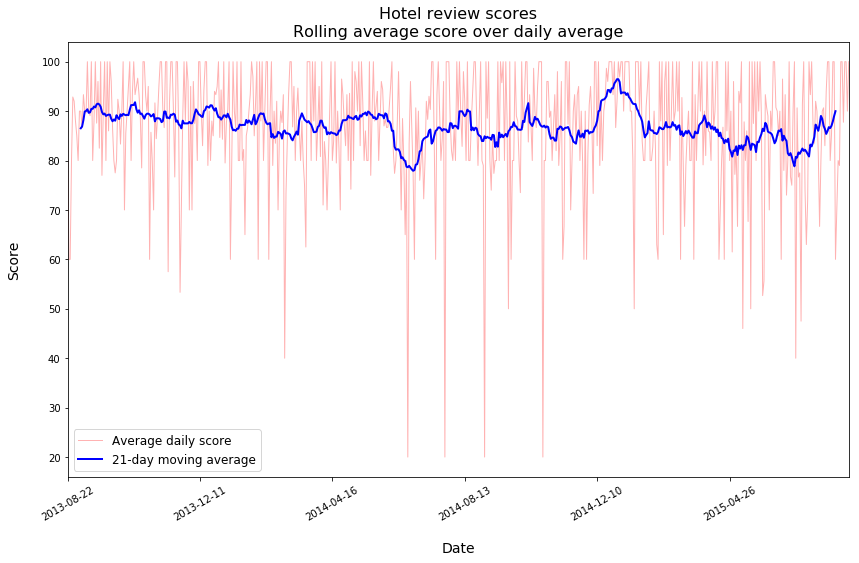

In [12]:
# Have a look at the moving average score over the given timeline
fig, ax = plt.subplots(1)
daily_scores.plot(lw=1, alpha=0.3, color='red', ax=ax)
#daily_count.plot(lw=2, alpha=0.7, color='green', ax=ax2, sharey=False)

rolling.plot(lw=2, color='blue', ax=ax, label='{}-day moving average'.format(freq), rot=30)
ax.set_title('Hotel review scores\nRolling average score over daily average', size=16)
ax.legend(['Average daily score',
           '{}-day moving average'.format(freq)], loc='best', fontsize=12)
ax.set_xlabel('\nDate', size=14)
ax.set_ylabel('Score\n', size=14);

You could say from the graph that there is a slight downward trend, about 3 score points per year. This could be because the hotel is dropping its standards, but another explanation would be that the score generally falls for products (not only hotels) once the number of scores increases. Just think about amazon products with 5-stars after 10 reviews. Rarely see things with 5 stars after 100 reviews.

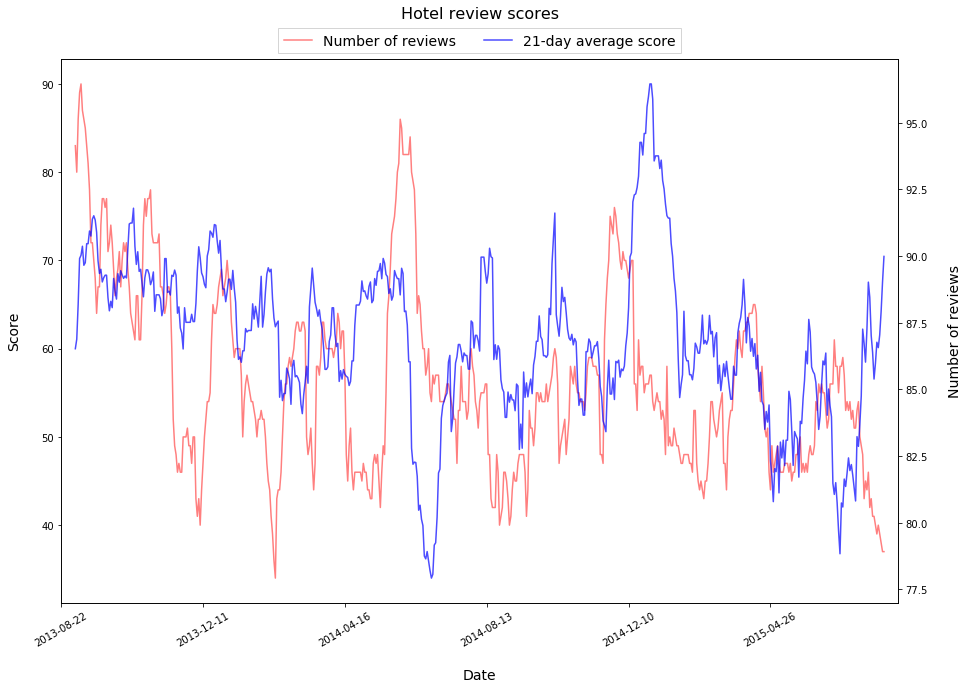

In [13]:
# see if the number of reviews is correlated with the average score
daily_count = scores.groupby('Date').aggregate(lambda x: len(x))
daily_count.sort_index(ascending=True, inplace=True)
# compute moving sum of reviews
rolling_count = daily_count.rolling(window=freq, center=True).sum()

# Create matplotlib figure
fig = plt.figure(figsize=(15,10))

# Create axes for each dataset
ax = fig.add_subplot(111)
ax2 = ax.twinx()

# plot the number of reviews
rolling_count.plot(lw=1.5, alpha=0.5, color='red', ax=ax, legend=False, rot=30)
# plot the rolling average score
rolling.plot(lw=1.5, alpha=0.7, color='blue', ax=ax2)

ax.set_title('Hotel review scores\n\n', size=16)

ax.grid(False)
ax2.grid(False)

ax.set_xlabel('\nDate', size=14)
ax.set_ylabel('Score\n', size=14);
ax2.set_ylabel('\nNumber of reviews', size=14)

# Put a legend below title
ax2.legend([ax.get_lines()[0], ax2.get_lines()[0]],
           ['Number of reviews', '{}-day average score'.format(freq)],
           loc='upper center', bbox_to_anchor=(0.5, 1.07),
           fancybox=False, shadow=False, ncol=2, fontsize=14);

Looks like there is some correlation in that the average score seems to drop after large amounts of reviews come in... there are a few ways to interpret that!

#### Could do further analysis here like exponentially decaying importance of average scores over time, or some other kind of chunking in time.

In [14]:
# for example...

df = pd.merge(left=daily_count, right=daily_scores, left_index=True, right_index=True, how='outer')
x = pd.concat([df.ewm(alpha=0.5, adjust=True, min_periods=5).mean()[5:20], df[5:20]], axis=1)
x.columns = ['EWA Count', 'EWA Score', 'Review count', 'Review score']
x.head(10)

,EWA Count,EWA Score,Review count,Review score
Date,,,,
2013-08-27,4.920635,87.654195,5.0,92.000000
2013-08-28,4.960630,87.828459,5.0,88.000000
2013-08-29,4.478431,86.408683,4.0,85.000000
2013-08-30,3.737769,83.198071,3.0,80.000000
2013-08-31,3.869013,86.602360,4.0,90.000000
2013-09-01,7.936492,88.302010,12.0,90.000000
2013-09-02,5.467643,87.484139,3.0,86.666667
2013-09-03,4.233671,90.409093,3.0,93.333333
2013-09-04,4.616859,90.204534,5.0,90.000000


## Time-series analysis

Make some predictions for the Score based on recent scores and the number of reviews over the last 2-3 days.

Admitedly this part has not been done really thoroughly, using cross-validation or fine-tuning of model parameters. The idea is just to show that it may be possible to predict how a hotel's score will move in the next time-periods based on a few variables (here the past scores and the number of reviews). Additional variables could be added if available.

In [15]:
df = pd.merge(left=daily_count, right=daily_scores, left_index=True, right_index=True, how='outer')
df.columns = ['Review count', 'Rolling score']
df.head()

,Review count,Rolling score
Date,,
2013-08-22,4.0,92.500000
2013-08-23,1.0,60.000000
2013-08-24,2.0,60.000000
2013-08-25,3.0,80.000000
2013-08-26,7.0,92.857143


Create a simple dataset using the values and their laged values, according to an equation of the form:

$$ y_t = \beta^{y}_{t-1} \cdot y_{t-1} + \beta^{y}_{t-2} \cdot y_{t-2} +
\beta^{x}_{t-1} \cdot x_{t-1} + \beta^{x}_{t-2} \cdot x_{t-2} + \epsilon $$

This shows we are predicting $y$ based on its previous two values as well as the previous two values of another variable, $x$

### Create a dataset

In [16]:
import statsmodels.api as sm

# use simple slicing to create train/test sets
n = df.shape[0]
train = int(0.9 * n)
# test = int(0.1 * n) --> we can just go to the end
df.sort_index(ascending=False)

# create our target variable, the dependent var
dep_var = df[['Rolling score']][2:]    # remove first two rows as we lose them in creating lags below

# create some independent variables out of our two variables, additionally using their lagged values
dv = df[['Rolling score']]
iv = df[['Review count']]
indep_vars = pd.concat([dv.shift(1), dv.shift(2), iv, iv.shift(1), iv.shift(2)], axis=1).dropna()
indep_vars.columns = ['score_lag1', 'score_lag2', 'count', 'count_lag1', 'count_lag2']
indep_vars.head()

/home/n1k31t4/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,score_lag1,score_lag2,count,count_lag1,count_lag2
Date,,,,,
2013-08-24,60.000000,92.500000,2.0,1.0,4.0
2013-08-25,60.000000,60.000000,3.0,2.0,1.0
2013-08-26,80.000000,60.000000,7.0,3.0,2.0
2013-08-27,92.857143,80.000000,5.0,7.0,3.0
2013-08-28,92.000000,92.857143,5.0,5.0,7.0


In [17]:
# simple autoregressive model using 5 lags
model = sm.GLM(endog=dep_var[:train], exog=indep_vars[:train], family=sm.families.Gaussian())
fit = model.fit(maxiter=2000, alpha=0.01)

# predict the score for the next week
preds = pd.DataFrame(fit.predict(exog=indep_vars[train:]))

In [18]:
# create a dataframe of the correct values along with the predicted values
to_plot = pd.merge(left=df[['Rolling score']][train:], right=preds, left_index=True, right_index=True, how='inner')
to_plot.columns = ['True Score', 'Predicted Score']

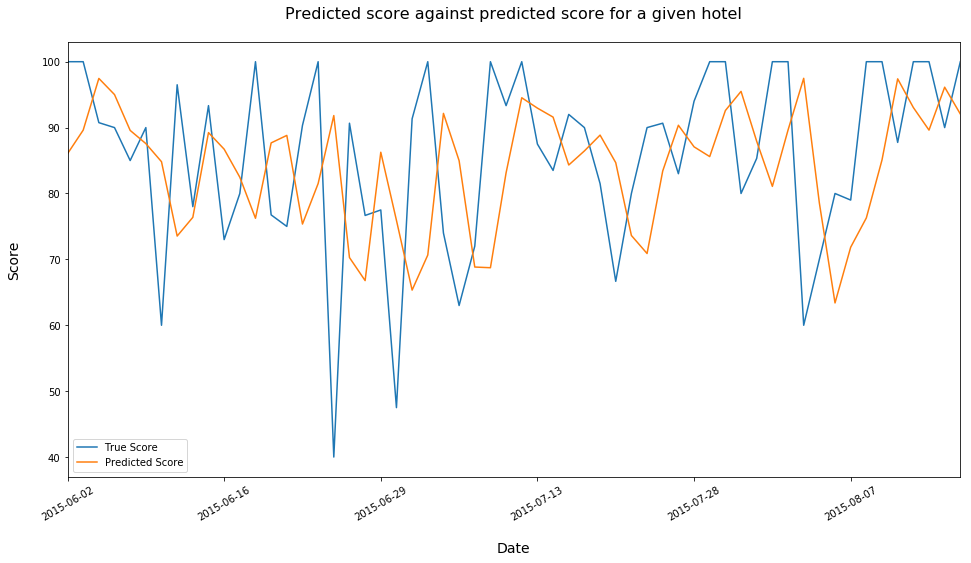

In [19]:
ax = to_plot.plot(rot=30, figsize=(16, 8))
ax.set_title('Predicted score against predicted score for a given hotel\n', size=16)
ax.set_xlabel('\nDate', size=14)
ax.set_ylabel('Score\n', size=14);

Clearly a poor model, as the predictions are basically following the trend, always behind by a few days (i.e. by the number of lags included) - the model could be improved using more thought and the inclusion of other variables.

# Working with the 'Text' data

I look at the entire text available for a single hotel (using the combined title and body corpus, as concatenated somewhere above). One could imagine also splitting this down into time blocks for a time-series version fo the same analyses.

I clean the text by removing stopwords/symbols, performing stemming/lemmatisation and then using the **spaCy** parser to get POS tagging and so on. This is done using a sklearn `Pipeline`. 

I first look at the adjectives that are most often associated with certain terms often deemed *important* by hotel guests/reviewers. For example, I see which adjectives are most often used to describe things like: room, staff, location, wifi, price, guests, bathroom etc. The results are put into a summary template (sorry, nothing too exciting here!).

In [20]:
# extract the texts and look at the top 10 words according to occurence
texts = data.Text.tolist()
all_text = '. '.join(texts)
count = Counter(all_text.split())
count.most_common(10)    # not surprising, having not yet removed stopwords

[('the', 10628),
 ('and', 8050),
 ('a', 5607),
 ('to', 5556),
 ('was', 4436),
 ('in', 3792),
 ('of', 3350),
 ('is', 3167),
 ('The', 2796),
 ('I', 2596)]

###  Improving the text

Remove standard stopwords and improve robustness for useful words.

Other idea: see if there are any domain specific words that should be either added to the stoplist or kept as an important review attribute. A custom vector representation of all reviews could be built, which would allow for similarity metrics between hotels. This would be something like training a word2vec, doc2vec or (my new favourite) sense2vec model and importing that into `spaCy` to augment the results with POS tagging, TFIDF, etc.

In [21]:
# Create a more complete stoplist by simply combining standard ones and adding tokens of our own
STOPWORDS = set(nltk.corpus.stopwords.words('english') +
                ["'ve", "'s", "'m", "'d", "'t", "n't", "\n", "\nn", "\t", "\r", "\r\r", "   ", "  "] +
               list(sklearn.feature_extraction.stop_words.ENGLISH_STOP_WORDS))

# Also create a set of punctuation and general symbols that won't tell us much
SYMBOLS = set(' '.join(string.punctuation).split(' ') +
              ['---', '--', '...',  '..', '“', '”', '==', '++'])

# create one master set
STOPSET = STOPWORDS.union(SYMBOLS)

#### Custom typo correction

Everyone knows that wifi (for example) is super important... let's not lose any such terms to due to typos!

Below I create a _hacky_ function to create all permutations of half-likely typos for a given word. These are then found and replaced with the intended word. Could also perform this quite robustly with regex instead of permutations.

In [22]:
def correct_term(text:    str,
                 desired: str  = r'wifi',
                 typos:   list = [r'wifi', r'wwiif', r'wiff', r'wogi', r'wifo', r'wofo'],
                 verbose: bool = True) -> str:
    
    """A hack to look for typos of a _desired_ word.
    Search for any permutations of the typos and replace them with the desired word
    The _typos_ may not be shorter in length than the _desired_ word.
    
    :param text:    the collection of words upon which to work
    :param desired: the word of interest to replace and suspected typos thereof
    :param typos:   a collection of possible typos for the _desired_ word
    :return:        the amended list of words, with typos replaced with _desired_ word
    """

    for typo in typos:
        assert len(typo) >= len(desired), "Each of the typos must satisfy: len(typo) >= len(desired)"
    
    for typo in typos:
        for perm in permutations(typo):
            perm = ''.join(perm)
            text = text.replace(perm, desired)

    return text

In [23]:
# test it out
test_typos = 'A hotel with great wofo and wiif on top of splendid woof, owgi & wifi'
corrected = correct_term(text=test_typos, desired='wifi')
corrected

'A hotel with great wifi and wifi on top of splendid wifi, wifi & wifi'

#### Look at frequency of words according to initial cleaning method

First look at counts without cleaning

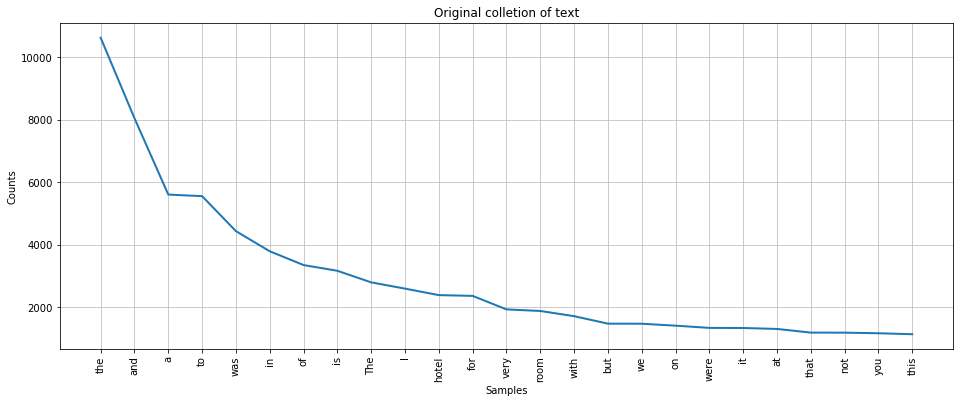

In [24]:
dirty_dist = nltk.FreqDist(all_text.split())
plt.figure(figsize=(16, 6))

# Have a look at the top 25 words by frequency
dirty_dist.plot(25, title='Original colletion of text')

Create a cleaning function that corrects for typos and also removes stopwords according to the parsed text:

In [25]:
def cleaner(text:        str,
            parser:      spacy.en.English,
            stoplist:    Sequence[str],
            corrections: bool = False, **kwargs) -> Sequence[str]:
    """
    Remove provided stopwords and symbols from collections of text.
    A list of words to correct if mispelled may also be specified.
    
    :param text:      a `list` of words to be cleaned
    :param stopwords: a `set` of words to be removed from _text_
    :corrections:     If False, do nothing. If True, correct permutations
                      of words in accompanying kwarg: _correction_list_
    :returns:         a list of words, with stopwords and symbols removed
    
    :kwargs:          _correction_dict_: if _corrections_ is True,
                      must provide {key=desired : values=typos}. typos is 
                      a list of possible mispellings of _desired_.
    """
    correction_dict = kwargs.get('correction_dict', None)
      
    # correct any useful words that were mispelled
    # this only will replace permutations of the desired word
    if corrections:
        for desired, typos in correction_dict.items():
            text = correct_term(text.lower(), desired, typos)

    # parse the text to remove things more effectively
    tokens = parser(text)
    
    # remove tokens found in the stopset (stopwords & symbols)
    text = [token.text for token in tokens if token.lower_ not in stoplist]
    text = [word for word in text if word != ' ']
    
    return text

Have a look how the top words change...

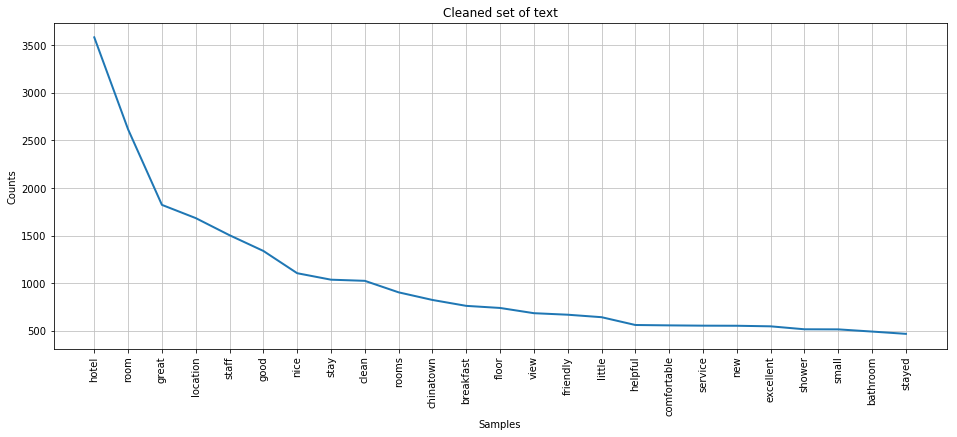

In [26]:
clean_text = cleaner(all_text, parser=nlp_en, stoplist=STOPSET, corrections=True, 
                     correction_dict={'wifi': ['wifi'],
                                      'location': ['location']})

clean_dist = nltk.FreqDist(clean_text)
plt.figure(figsize=(16, 6))

# Have a look at the top 25 words by frequency
clean_dist.plot(25, title='Cleaned set of text')

Try a different function aimed at keeping text as close to correctly writen English as possible. It doesn't use a parser for POS pruning etc.

In [27]:
def text_cleaner(text:     str,
                 stoplist: Sequence[str] = False) -> str:
    """
    A function to standardise the text input as much as possible.
    Attempts to bring the text as close to 'correctly' written English as possible,
    with the goal of facilitating more accurate parsing.
    
    :param text:      a body of words to be cleaned
    :param stopwords: an optional collection of words to be removed from _text_
    :returns:         a body of standardised text

    """
    # remove whitespace
    whitespace1 = re.compile(r'\s', re.I)
    whitespace2 = re.compile(r' {2,}', re.I)
    text = whitespace1.sub(r' ', text)
    text = whitespace2.sub(r' ', text)
     
    # remove non-useful symbols and numbers
    to_remove = re.compile(r'[^a-zA-Z.,() ]', re.IGNORECASE)
    text = to_remove.sub('', text)

    # remove words found in the stoplist. Keep 
    # For effective parsing later, recreate sentences after splitting into words
    if stoplist:
        words = text.split()
        text = [word for word in words if word.lower() not in stoplist]
        text = ' '.join(text)

    # catch some other artefacts of cleaning: a good-to-have last step
    text = (text
            .replace(r' , ', r', ')
            .replace(r', ,', r', ')
            .replace(r', .', '.')
            .replace(r' . ', r'. ')
            .replace(r'  ', r' ')
            .replace(r'  ', ' '))
        
    return text

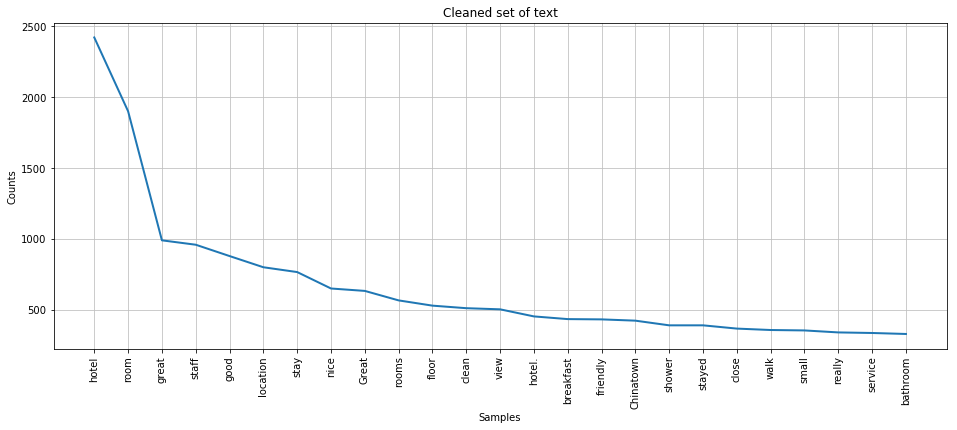

In [28]:
clean_text = text_cleaner(all_text, stoplist=STOPSET)

clean_dist = nltk.FreqDist(clean_text.split())
plt.figure(figsize=(16, 6))

# Have a look at the top 25 words by frequency
clean_dist.plot(25, title='Cleaned set of text')

This last function `clean_text` runs a lot quicker, but at the cost of containing some duplicates and strange entries, such as 'hotel.' - this can be combatted with the teokenise_text function belo.

### POS analysis

Look at the words for their semantic meanings in order to answer some questions we want to answer regarding the hotel.

###### Look at some ways that "WiFi" has been used and described

In [29]:
# use only first hotel
df1 = data[data.ID == '1.Hotel']
# get just the text
text = df1.Text.aggregate(sum)

# parse the text using spaCy
doc = nlp_en(text)

In [30]:
# get the sentiences including "wifi"
wifi_sents = [sent for sent in doc.sents if 'wifi' in sent.string]

In [31]:
# find all words used to describe wifi

wifi_adjs_test = []

for sent in wifi_sents: 
    for word in sent:
        if 'wifi' in word.string.lower():
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)
                    wifi_adjs_test.append(child.string[:-1])
                    
# Nice!

Free
free
free
free
free
poor
quiet
reliable
free
good
free
free
Free
Free
free
free
Free
good
clean
free
free
free


<img align="left",src="./wait-what-.png",width=250,height=250>

#### Wait... the wifi was 'quiet' and 'clean' ??

This sort of lexical parsing issue is difficult to catch. If somebody writes for example: "Good hotel, rooms quiet, clean, wifi, big pool". Even with 'big data', poor/abbreviated English would be difficult a difficult problem to solve via models alone. As an approach to tackle these kind of _polysemy_ issues, I would look into a current implementation in spaCy called **sense2vec**...

In [32]:
# Let's see the offending sentence...
for sent in doc.sents:
    if ('wifi' in sent.string) and ('quiet' in sent.string):
        print(sent.string)

The only negative was that when my room wasn't ready at 2:45, and I complained b/c I really needed to make a call over wifi in a quiet place, they said "we only guarantee the room for 3pm". 
The hotel and room was modern,clean,included wifi and surprisingly quiet inside for The City. 


###### Define a function to find all adjectives used to describe a given word

The below function just packs the above work together

In [33]:
def get_adjs(word: str, sentences: Sequence[str],
            return_strings: bool=True,
            verbose: bool=True) -> Sequence[str]:
    """For a list of _sentences_ containing the given _word_,
    find all adjectives used to describe the _word_.
    The _sentences_ will be pruned to use only those containing _word_.
    If the _sentences_ are already pruned, the output is identical.
    
    :param word:           this word's associated adjectives are found
    :param sentences:      a parsed document or list of sentences produced by a _spaCy_ parser
    :param return_strings: if False, function return a list of <class 'spacy.tokens.token.Token'>
    :param verbose:        if False, do not print information during processing
    :return:               list of adjectives, containing any duplicates
    
        
    Note: if proper nouns are to be described, the function must be improved.
          It currently works using only lower case search words
    """

    # if the delivered sentences are spacy, get the desired sentence, otherwise take them 'as are'.
    try:
        sents = [sent for sent in sentences.sents if word in sent.string]
    except AttributeError:
        if verbose:
            print('Processing provided sentences')
        sents = sentences
        
    adjectives = []
    
    for sent in sents: 
        for token in sent:
            if word in token.string.lower():
                for child in token.children: 
                    if child.pos_ == 'ADJ':
                        if return_strings:
                            adjectives.append(child.string[:-1])
                        else:
                            adjectives.append(child)
                        
    return adjectives


Ensure that the results are consistent, whether or not a parsed document is used or a collection of spacy sentences.

In [34]:
x = get_adjs(word='wifi', sentences=doc, return_strings=True, verbose=False)
y = get_adjs(word='wifi', sentences=wifi_sents, return_strings=True, verbose=False)

# test that results are identical
x == y

True

#### Aside: Performace checks, because those nested loops look painfully inefficient...

In [35]:
def get_adjs_quicker(word: str,
                     sentences: Sequence[str],
                     return_strings: bool=True,
                     verbose: bool=True) -> Sequence[str]:
    """For a list of _sentences_ containing the given _word_,
    find all adjectives used to describe the _word_.
    The _sentences_ will be pruned to use only those containing _word_.
    If the _sentences_ are already pruned, the output is identical.
    
    :param word:           this word's associated adjectives are found
    :param sentences:      a parsed document or list of sentences produced by a _spaCy_ parser
    :param return_strings: if False, function return a list of <class 'spacy.tokens.token.Token'>
    :param verbose:        if False, do not print information during processing
    :return:               list of adjectives, containing any duplicates
        
    Note: if proper nouns are to be described, the function must be improved.
          It currently works using only lower case search words
    """

    # if the delivered sentences are spacy spans, get the desired sentence, otherwise take them as they are.
    try:
        sents = [sent for sent in sentences.sents if word in sent.string]
    except AttributeError:
        if verbose:
            print('Processing provided sentences')
        sents = sentences
    
    # same as above but as a mega list comprehension... not exactly comprehendible, but faster?
    adjectives = [child.string[:-1] if return_strings else child \
     for sent in sents for token in sent  if word in token.string.lower() \
     for child in token.children if child.pos_ == 'ADJ']

    return adjectives

In [36]:
# ensure the two variants of the function give identical output (and same as initial rough test above)
wifi_adjs = get_adjs(word='wifi', sentences=doc, return_strings=True, verbose=True)
wifi_adjs_quicker = get_adjs_quicker(word='wifi', sentences=doc, return_strings=True, verbose=True)

# test
wifi_adjs_test == wifi_adjs == wifi_adjs_quicker

True

First check if the list comprehension made an impact at all.  Seems to offer a nice speedup of approx. 30%.

In [37]:
print('\nOriginal nested loop implementation...\n')
cProfile.run("get_adjs(word='wifi', sentences=doc, return_strings=True, verbose=True)", sort=True)

print('\nList comprehension equivalent...\n')
cProfile.run("get_adjs_quicker(word='wifi', sentences=doc, return_strings=True, verbose=True)", sort=True)


Original nested loop implementation...

         615 function calls in 0.051 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.050    0.050    0.050    0.050 <ipython-input-33-b1cb5f73b596>:22(<listcomp>)
        1    0.000    0.000    0.051    0.051 <ipython-input-33-b1cb5f73b596>:1(get_adjs)
      588    0.000    0.000    0.000    0.000 {method 'lower' of 'str' objects}
        1    0.000    0.000    0.051    0.051 {built-in method builtins.exec}
        1    0.000    0.000    0.051    0.051 <string>:1(<module>)
       22    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



List comprehension equivalent...

         594 function calls in 0.050 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.049    0.049    0.049    0

Run the functions a few times to get a feel for this difference in timings...

In [38]:
%%timeit -n 10
get_adjs(word='wifi', sentences=doc, return_strings=True, verbose=True)

10 loops, best of 3: 50.2 ms per loop


In [39]:
%%timeit -n 10
get_adjs_quicker(word='wifi', sentences=doc, return_strings=True, verbose=True)

# that makes me sad. Likely due to the overhead of the `timeit` magic-module in Jupyter

10 loops, best of 3: 49.4 ms per loop


Second: check to see what the rough overhead is for parsing the document (this is ca. 1400 reviews) as opposed to proving the parsed sentences of interest. Seems to be fairly scalable, given the number of reviews. The text parsing/tokenisation would need to be performed anyway sooner or later in the pipeline.

In [40]:
%%timeit -n 10

get_adjs(word='wifi', sentences=doc, return_strings=True, verbose=True)

10 loops, best of 3: 49 ms per loop


In [41]:
%%timeit -n 10

get_adjs(word='wifi', sentences=wifi_sents, return_strings=True, verbose=False)

10 loops, best of 3: 233 µs per loop


I did also check whether a generator versus iterator for creating `sents` (in the `try`) makes much difference... it didn't.

In [42]:
# create a separate function, an exact copy of `get_adjs_quicker`, which get the adverbs for us
def get_advs_quicker(word:           str, 
                     sentences:      Sequence[str],
                     return_strings: bool=True,
                     verbose:        bool=True) -> Sequence[str]:
    """For a list of _sentences_ containing the given _word_,
    find all adverbs used to describe the _word_.
    The _sentences_ will be pruned to use only those containing _word_.
    If the _sentences_ are already pruned, the output is identical.
    
    :param word:           this word's associated adverbs are found
    :param sentences:      a parsed document or list of sentences produced by a _spaCy_ parser
    :param return_strings: if False, function return a list of <class 'spacy.tokens.token.Token'>
    :param verbose:        if False, do not print information during processing
    :return:               list of adverbs, containing any duplicates
    
    Note: if proper nouns are to be described, the function must be improved.
          It currently works using only lower case search words
    """

    # if the delivered sentences are spacy spans, get the desired sentence
    # otherwise take them as they are.
    try:
        sents = [sent for sent in sentences.sents if word in sent.string]
    except AttributeError:
        if verbose:
            print('Processing provided sentences')
        sents = sentences
    
    # Extract the adverbs
    adverbs = [child.string[:-1] if return_strings else child \
     for sent in sents for token in sent if word in token.string.lower() \
     for child in token.children if child.pos_ == 'ADV']

    return adverbs

Test out the adjective getter over the entire text of the first hotel... Doesn't find anything really useful or meaningful. May potentially work better on a larger corpus.

In [43]:
Counter(get_advs_quicker('room', nlp_en(text), return_strings=True)).most_common(5)

[('just', 3), ('Even', 3), ('outside', 2), ('higher', 2), ('essentially', 2)]

### The main NLP function:

In [44]:
def tokenise_text(sample: str,
                 stoplist: Sequence[str],
                 parser: spacy.en.English) -> (str, Sequence['token']):
    """Tokenise input using a spaCy nlp parsing model. Tokenisation is augmented with lemmatisation.
    This function also removes words found in the stoplist
    
    :param sample:   input sample text
    :param stoplist: the list of words to remove if found
    :parser:         a model from the spacy module. E.g. parser = spacy.load('en_core_web_md')
    :returns:
        1) cleaned_sample = The cleaned version of the input text
        2) tokens         = the parsed and cleaned input sample text,
                         each word is a spacy token (not a string)
    """
    assert callable(parser), "Give me a function as parser please! Preferably from _spaCy_."
    
    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatise the text and conserve capitalised pronouns
    lemmas = []
    for token in tokens:
        lemmas.append(token.lemma_ if token.lemma_ != '-PRON-' else token.lower_)
    tokens = lemmas

    # remove tokens found in the stopset (stopwords & symbols)
    tokens = [token for token in tokens if token not in stoplist]

    # catch any remaining blocks of whitespace
    tokens = [token for token in tokens if token not in ["", " ", "\n", "\n\n"]]
    
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    # locate and correct any possible typos of 'wifi' and 'internet'
    tokens = correct_term(' '.join(tokens), desired='wifi')    # use the default typos for wifi
    tokens = correct_term(tokens, desired='internet', typos=['internet', 'interneet'])
    
    tokens = tokens.split()

    # Having ruthlessly removed many words, the formatting might be weird
    # We can restore it a little if necessary
    rebuild = []
    for token in tokens:
        rebuild.append(' ' + token) if token not in ".," else rebuild.append(token + ' ')
    cleaned_sample = ''.join(rebuild).strip().replace(r"  ", r" ")
    
    return cleaned_sample, tokens

## Creating summaries

The approach goes with templates, finding how different aspects of the hotel were described and building simple sentences out of them. Some checks can be made for robustness and also some sanity checking, that the created English is actually correct.

Start by defining a list of 'attributes' that are important when deciding which hotel to book...

### Test a pipeline for extracting the adjectives and adverbs

In [45]:
# this list (for now) must be all nouns, and the lemmatised version too
attributes = ['location', 'wifi', 'breakfast', 'food', 'room', 'bed',
              'staff', 'price', 'quality', 'parking', 'hotel']

In [46]:
# use only first hotel
text = data[data.ID == '1.Hotel']

# get just the text
text = text.Text.aggregate(sum)

# perform general standarisation of text (initial cleaning) - doesn't remove stopwords
text = text_cleaner(text)

# further clean and additionally lemmatise the text
clean_text, word_list = tokenise_text(text, STOPSET, parser=nlp_en)

# parse the text using spaCy
doc = nlp_en(clean_text)

# find the adjectives of all our attributes of interest
adjs = {attrib: get_adjs_quicker(word=attrib, sentences=doc, return_strings=True) for attrib in attributes}

# find the adverbs used to describe our attributes
advs = {attrib: get_advs_quicker(word=attrib, sentences=doc, return_strings=True) for attrib in attributes}

In [47]:
# Get top 5
adjs_top5 = {attr: Counter(adjs[attr]).most_common(5) for attr in attributes}
advs_top5 = {attr: Counter(advs[attr]).most_common(5) for attr in attributes}

In [48]:
adjs_top5

{'bed': [('comfortable', 28),
  ('clean', 22),
  ('comfy', 19),
  ('small', 13),
  ('great', 12)],
 'breakfast': [('nice', 7),
  ('continental', 7),
  ('good', 5),
  ('poor', 3),
  ('clean', 3)],
 'food': [('good', 12),
  ('chinese', 10),
  ('great', 6),
  ('favourite', 3),
  ('amazing', 3)],
 'hotel': [('great', 100),
  ('nice', 92),
  ('good', 73),
  ('clean', 68),
  ('new', 45)],
 'location': [('great', 142),
  ('good', 82),
  ('clean', 22),
  ('nice', 21),
  ('excellent', 17)],
 'parking': [('busy', 2),
  ('noisy', 1),
  ('available', 1),
  ('friendly', 1),
  ('helpful', 1)],
 'price': [('good', 18),
  ('great', 15),
  ('reasonable', 7),
  ('little', 4),
  ('fantastic', 4)],
 'quality': [('high', 6),
  ('good', 5),
  ('lower', 1),
  ('manhattan', 1),
  ('big', 1)],
 'room': [('clean', 171),
  ('great', 109),
  ('nice', 106),
  ('small', 80),
  ('good', 73)],
 'staff': [('friendly', 99),
  ('clean', 79),
  ('great', 74),
  ('nice', 43),
  ('helpful', 37)],
 'wifi': [('free', 21), ('

In [49]:
def summarise(text: str,
              attributes: Sequence[str],
              adverbs: bool = False) -> str:
    
    """Use a pipeline of text cleaning and semantic relationship search based on POS tags
    to generate a list of sentences to summarise a hotel
    
    :param text:       the base input text e.g. a corpus of reviews for a given hotel
    :param attributes: list of attributes to search for a describe
    :return:           a text block that summarises a hotel
    """

    # perform general standarisation of text (initial cleaning) - doesn't remove stopwords
    text = text_cleaner(text)

    # further clean and additionally lemmatise the text
    clean_text, word_list = tokenise_text(text, STOPSET, parser=nlp_en)

    # parse the text using spaCy
    doc = nlp_en(clean_text)

    # find the adjectives of all our attributes of interest
    adjs = {attrib: get_adjs_quicker(word=attrib, sentences=doc, return_strings=True) for attrib in attributes}
    # get top 5
    adjs_top5 = {attr: Counter(adjs[attr]).most_common(5) for attr in attributes}
    
    # find the adverbs used to describe our attributes if wanted
    if adverbs:
        advs = {attrib: get_advs_quicker(word=attrib, sentences=doc, return_strings=True) for attrib in attributes}
        advs_top5 = {attr: Counter(advs[attr]).most_common(5) for attr in attributes}
    else:
        advs_top5 = None
    
    return adjs_top5, advs_top5

In [50]:
def summary_builder(attributes: Sequence[str], 
                    top5_adjs: dict) -> str:
    """
    Construct a paragraph of text using the discovered adjectives
    
    :param attributes:  a list of attributes that were used in the _summarise_ function
    :param top5_adjs:   a dictionary whose keys are the _attributes_ with corresponding values
                        being the top 5 adjectives used to describe each attribute.
    :return:            a block of text
    """

    sentences = {}
    
    sentences['location']  = "This hotel's location is {}. Many guests also described it as {}.".format(top5_adjs['location'][randint(0,2)][0], 
                                                                                                                 top5_adjs['location'][randint(3,4)][0])
    sentences['wifi']      = "The wifi is {} and {}.".format(top5_adjs['wifi'][0][0], top5_adjs['wifi'][1][0])
    sentences['food']      = "The hotel's food offering is rather {} and breakfast is usually {}.".format(top5_adjs['food'][randint(0,2)][0],
                                                                                                         top5_adjs['breakfast'][randint(0,2)][0])
    sentences['room']      = 'Rooms are {} and {} with {} beds.'.format(top5_adjs['room'][randint(0,2)][0],
                                                                        top5_adjs['room'][randint(3,4)][0],
                                                                        top5_adjs['bed'][randint(0,4)][0])

    sentences['staff']     = 'Most guests found Reception staff and assistants to be {} and {}.'.format(top5_adjs['staff'][randint(0,2)][0], 
                                                                                                       top5_adjs['staff'][randint(3,4)][0])
    sentences['price']     = 'This quality is {} for the price,'.format(top5_adjs['price'][0][0])
    sentences['parking']   = 'Opportunities to park are {}.'.format(top5_adjs['parking'][randint(0,1)][0])
    sentences['quality']   = 'Overall the quality is {} and the hotel left a {} impression.'.format(top5_adjs['quality'][randint(0,2)][0],
                                                                                                    top5_adjs['hotel'][randint(0,2)][0])
    
    num_sents = len(sentences.keys())
    
    # pick sentences at random
    random_selection = sample(range(num_sents), num_sents)
    
    sentences = [sentence for _, sentence in sentences.items()]
    
    # Build a paragraph
    paragraph = []
    for selection in random_selection:
        paragraph.append(sentences[selection])
        
    final_paragraph = ' '.join(paragraph)
    
    return final_paragraph

In [51]:
paras = {}
hotels = ['1.Hotel', '2.Hotel', '3.Hotel']

for hotel in hotels:

    print('Describing Hotel {}'.format(hotel[0]))
    
    # get single hotel's text
    text = data[data.ID == hotel]

    # get just the text
    text = text.Text.aggregate(sum)
    
    # get the adjectives
    top5_adjs, _ = summarise(text, attributes)
    
    print('Got adjectives... Now building paragraph')
    
    # create the paragraphs
    paras[hotel] = summary_builder(attributes=attributes, top5_adjs=top5_adjs)

Describing Hotel 1
Got adjectives... Now building paragraph
Describing Hotel 2
Got adjectives... Now building paragraph
Describing Hotel 3
Got adjectives... Now building paragraph


In [54]:
# show each hotel's summary
for hotel, summary in paras.items():
    print('\n\nHotel #{}\n'.format(hotel[0]))
    print(paras[hotel])



Hotel #1

Most guests found Reception staff and assistants to be great and nice. Opportunities to park are busy. Overall the quality is good and the hotel left a nice impression. This hotel's location is clean. Many guests also described it as nice. This quality is good for the price, The hotel's food offering is rather great and breakfast is usually good. The wifi is free and good. Rooms are great and small with great beds.


Hotel #2

The hotel's food offering is rather amazing and breakfast is usually good. This hotel's location is good. Many guests also described it as stunning. Opportunities to park are free. Most guests found Reception staff and assistants to be good and helpful. The wifi is free and delicious. This quality is high for the price, Overall the quality is high and the hotel left a great impression. Rooms are nice and beautiful with large beds.


Hotel #3

The wifi is free and good. Most guests found Reception staff and assistants to be nice and good. This hotel's 